In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
x = torch.linspace(0, 799, 800)

In [ ]:
y = torch.sin(x*2*3.1416/40)

In [ ]:
plt.figure(figsize =(14,4))
plt.xlim(-10, 801)
plt.grid(True)
plt.plot(y.numpy())

In [ ]:
test_size = 40
train_set = y[:-test_size]
test_set = y[-test_size:]

In [ ]:
plt.figure(figsize =(14,4))
plt.xlim(-10, 801)
plt.grid(True)
plt.plot(train_set.numpy())


In [ ]:
def input_data(seq, ws):
    out = []
    L = len(seq)
    
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window, label))
        
    return out

In [ ]:
window_size = 40

train_data = input_data(train_set, window_size)

In [ ]:
len(train_data)

In [ ]:
train_data[0]

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size = 1, hidden_size = 50, out_size = 1):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, out_size)
        
        self.hidden = (torch.zeros(1,1, hidden_size), torch.zeros(1,1, hidden_size))
        
    def forward(self, seq):
        
        lstm_out, self.hidden = self.lstm(seq.view(len(seq), 1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq), -1))
        
        return pred[-1]
        

In [ ]:
torch.manual_seed(42)
model = LSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [ ]:
epochs = 10
future = 40

for i in range(epochs):
    
    for seq, y_train in train_data:
        
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size), 
                       torch.zeros(1,1,model.hidden_size))
        
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    print(f"Epoch {i} Loss: {loss.item()}")
    
    preds = train_set[-window_size:].tolist()
    
    for f in range(future):
        seq = torch.FloatTensor(preds[-window_size:]) #naloaduj last winsize sequenciu
        
        with torch.no_grad():
            
            model.hidden = (torch.zeros(1,1,model.hidden_size),
                           torch.zeros(1,1,model.hidden_size))
            
            preds.append(model(seq).item())
    import pdb; pdb.set_trace()       
    loss = criterion(torch.tensor(preds[-window_size:]), y[760:])
    print(f"Performance on test range: {loss}")

    plt.figure(figsize = (14,4))
    plt.xlim(0, 841)
    plt.grid(True)
    plt.plot(y.numpy())
    plt.plot(range(800, 840), preds[window_size:])
    plt.show()
        
        

# Own Train set

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def LoadDataframe():
    df = pd.read_csv('reducedLstmData.csv', delimiter = ';', index_col = None)
    #df['target'] = df.price_close.diff()
    df['target'] = df.price_close.shift(-1)
    df = df.head(df.shape[0]-1)
    return df

In [6]:
def TrainTestSplit(df, ratio):
    train_size = int(len(df)*ratio)
    test_size = len(df)-train_size
    train_set = df.iloc[: train_size]
    test_set = df.iloc[-test_size:]

    return train_set, test_set

def input_data(seq, ws):
    out = []
    L = len(seq)
    
    for i in range(L-ws):
        window = seq.iloc[i:i+window_size]
        window_values = torch.cuda.FloatTensor(window.values)
        label = seq.target.iloc[i+ws:i+ws+1]
        label_value = torch.cuda.FloatTensor(label.values)
        out.append((window_values, label_value))
        
    return out

In [7]:
df = LoadDataframe()

In [8]:
window_size = 10
train_df, test_df = TrainTestSplit(df, 0.8)
train_data = input_data(train_df, window_size)

In [9]:
train_df.head(3)

,noTweets,sum_compound,avg_sum_compound,price_open,price_close,volume_traded,trades_count,target
0,2652,521.1693,0.196456,3992.70,3935.76,4.842621e+07,21271.0,3968.000000
1,2674,482.5923,0.180254,3999.00,3968.00,2.327041e+08,64705.0,3974.500000
2,2407,530.6851,0.220191,3966.89,3974.50,6.001377e+07,20275.0,3976.566307


In [10]:
test_df.head(1)

,noTweets,sum_compound,avg_sum_compound,price_open,price_close,volume_traded,trades_count,target
5720,3403,1042.9111,0.3062,8159.772955,8079.0,1.128682e+08,41789.0,8061.0


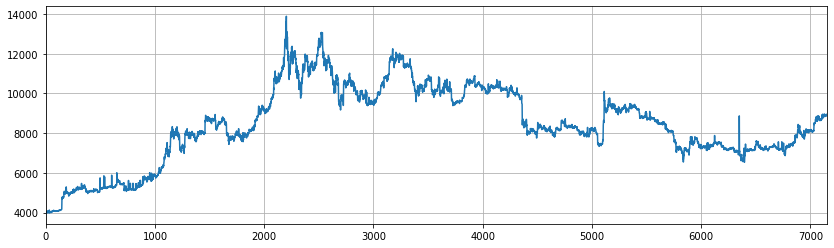

In [11]:
plt.figure(figsize =(14,4))
plt.xlim(0, train_df.shape[0]+test_df.shape[0])
plt.grid(True)
plt.plot(df.price_close)


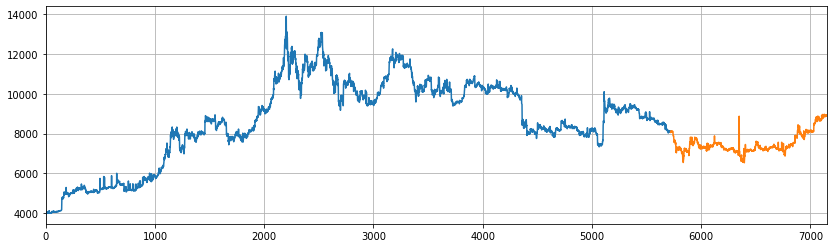

In [12]:
plt.figure(figsize =(14,4))
plt.xlim(0, train_df.shape[0]+test_df.shape[0])
plt.grid(True)
plt.plot(train_df.target)
plt.plot(test_df.target)

In [13]:
class MLSTM(nn.Module):
    def __init__(self, input_size = 8, hidden_size = 50, out_size = 1):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, out_size)
        
        #self.hidden = (torch.zeros(|1,1, hidden_size), torch.zeros(1,1, hidden_size))#tu sa musi nieco zmenit #dotrenovanie
        
    def forward(self, seq):
        #import pdb; pdb.set_trace()
        lstm_out, self.hidden = self.lstm(seq.view(len(seq), 1,-1))
        #lstm_oud, (hid, cell) = self.lstm(
        # pred[-1] = self.linear(hid)
        pred = self.linear(lstm_out.view(len(seq), -1))
        
        return pred[-1]
        

In [14]:
train_data[0][0].view(len(train_data[0][0]), 1,-1).shape

torch.Size([10, 1, 8])

In [15]:
torch.manual_seed(42)
model = MLSTM()
model.cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)

In [16]:
model.parameters()

<generator object Module.parameters at 0x000001F59741E6D8>

Epoch 0 Loss: 177328.171875
Performance on test range: 165910.5037143191


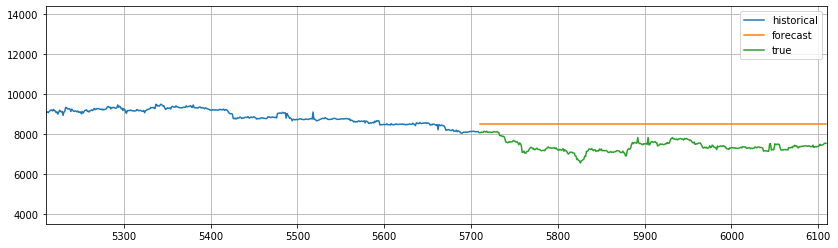

Epoch 1 Loss: 745603.5625
Performance on test range: 720371.2826824232


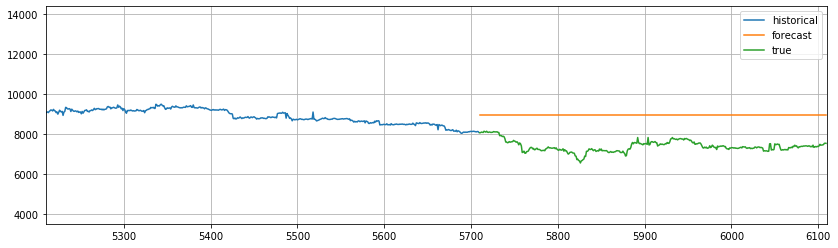

Epoch 2 Loss: 776037.125
Performance on test range: 750233.2183294396


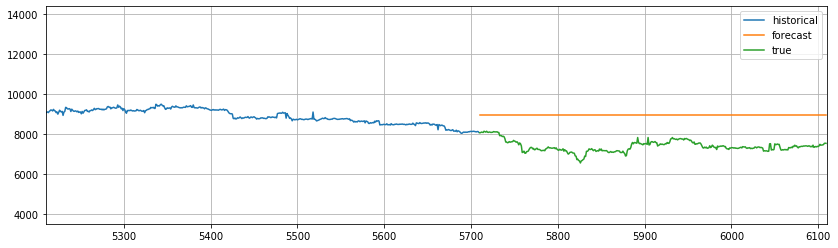

In [ ]:
epochs = 50
future = 400

for i in range(epochs):
    
    for seq, y_train in train_data:
        optimizer.zero_grad()
        #model.hidden = (torch.zeros(1,1,model.hidden_size), 
                       #torch.zeros(1,1,model.hidden_size)) # inicializacia
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    print(f"Epoch {i} Loss: {loss.item()}")
    
    preds = train_df[-window_size:].values
    #print(preds.shape)
    for f in range(future):
        #print(preds.shape)
        seq = torch.cuda.FloatTensor(preds[-window_size:])
        
        with torch.no_grad():
            
            model.hidden = (torch.zeros(1,1,model.hidden_size),
                           torch.zeros(1,1,model.hidden_size)) # taktiez zmena vah
            
            
            app = test_df.iloc[f:f+1].loc[:, test_df.columns != 'target'].values
            y_pred = np.array(model(seq).item())
            new = np.insert(app,7,y_pred)
            preds = np.insert(preds, preds.shape[0], new, axis=0)
            #import pdb; pdb.set_trace()
            #preds.append(model(seq).item())
            
    #import pdb; pdb.set_trace()
    loss = criterion(torch.tensor(preds[-window_size:][:,preds.shape[1]-1]), torch.tensor(test_df.iloc[0:window_size].target.values))
    print(f"Performance on test range: {loss}")

    #import pdb; pdb.set_trace()
    plt.figure(figsize = (14,4))
    plt.xlim(len(train_data)-500, len(train_data)+future)
    #plt.ylim(6000, 10000)
    plt.grid(True)
    plt.plot(train_df.iloc[window_size:].target.values, label='historical')
    plt.plot(range(len(train_data), len(train_data)+future), preds[-future:][:,7], label='forecast')
    plt.plot(range(len(train_data), len(train_data)+future), test_df.target.head(future).values, label='true')
    plt.legend(loc="upper right")
    plt.show()
        
        

In [ ]:
lstm = nn.LSTM(8, 2, batch_first=True)

In [ ]:
train_data[0][0].unsqueeze(0).shape

In [ ]:
train_data[0][0].float()

In [ ]:
torch.Tensor(train_data[0][0])

In [ ]:
lstm(train_data[0][0].float().unsqueeze(0))

In [ ]:
torch.zeros(1,1,50)